## Feature Selection

In [ ]:
!pip install pgmpy networkx scikit-learn pandas numpy matplotlib seaborn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 69.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MmhcEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import warnings

In [ ]:
# NSL-KDD feature list
columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"
]


In [ ]:
# dwld Data frm Git
!wget -q https://raw.githubusercontent.com/jmnwong/NSL-KDD-Dataset/master/KDDTrain%2B.txt -O KDDTrain+.txt
!wget -q https://raw.githubusercontent.com/jmnwong/NSL-KDD-Dataset/master/KDDTest%2B.txt -O KDDTest+.txt

In [ ]:
df = pd.read_csv('KDDTrain+.txt', names=columns)
print(df.shape)
df.head()

df = df.sample(n=10000, random_state=42) #slt 1k samples

df['label'] = df['label'].apply(lambda x: 'Normal' if x == 'normal' else 'Attack')

print(f"Data loaded: {df.shape}")

(125973, 43)
Data loaded: (10000, 43)


In [ ]:
print(df['label'])

378       Normal
32038     Attack
86399     Attack
74412     Attack
52951     Attack
           ...  
41546     Attack
101548    Normal
108008    Normal
9804      Normal
91180     Attack
Name: label, Length: 10000, dtype: object


Information Gain Calculation

In [ ]:
def entropy(series):
    """Calculate entropy of a pandas Series"""
    series = series.dropna()
    vc = series.value_counts()
    p = vc / len(series)
    return -np.sum(p * np.log2(p + 1e-10))

def information_gain(df, feature, target='label'):
    """Calculate Information Gain for one feature"""
    target_entropy = entropy(df[target])
    weighted_entropy = 0

    for value in df[feature].unique():
        subset = df[target][df[feature] == value]
        weight = len(subset) / len(df)
        weighted_entropy += weight * entropy(subset)

    return target_entropy - weighted_entropy

# Calculate for all features
features = [c for c in df.columns if c not in ['label', 'difficulty']]
ig_scores = {feat: information_gain(df, feat) for feat in features}

# Sort by descending IG
ig_sorted = dict(sorted(ig_scores.items(), key=lambda x: x[1], reverse=True))

# Display top features
for i, (feat, score) in enumerate(ig_sorted.items(), 1):
    print(f"{i:2}. {feat:25s}: {score:.6f}")


 1. src_bytes                : 0.831667
 2. service                  : 0.659919
 3. dst_bytes                : 0.640687
 4. diff_srv_rate            : 0.523551
 5. flag                     : 0.515680
 6. same_srv_rate            : 0.507803
 7. dst_host_srv_count       : 0.497833
 8. dst_host_same_srv_rate   : 0.433075
 9. dst_host_serror_rate     : 0.414727
10. dst_host_diff_srv_rate   : 0.414316
11. dst_host_srv_serror_rate : 0.408263
12. count                    : 0.401353
13. serror_rate              : 0.397849
14. logged_in                : 0.391603
15. srv_serror_rate          : 0.386480
16. dst_host_srv_diff_host_rate: 0.271793
17. dst_host_count           : 0.211094
18. dst_host_same_src_port_rate: 0.195101
19. srv_diff_host_rate       : 0.148402
20. srv_count                : 0.125865
21. dst_host_srv_rerror_rate : 0.084612
22. protocol_type            : 0.064438
23. dst_host_rerror_rate     : 0.058828
24. rerror_rate              : 0.057529
25. srv_rerror_rate          : 0.050

Mutual Information

In [ ]:
def mutual_information(df, feature, target='label'):
    """Calculate Mutual Information between one feature and the target."""
    h_feature = entropy(df[feature])
    h_target = entropy(df[target])

    # Joint entropy
    joint_dist = pd.crosstab(df[feature], df[target])
    total = joint_dist.sum().sum()
    joint_entropy = 0

    for i in joint_dist.index:
        for j in joint_dist.columns:
            pij = joint_dist.loc[i, j] / total
            if pij > 0:
                joint_entropy -= pij * np.log2(pij)

    mi = h_feature + h_target - joint_entropy
    return mi


# Calculate MI for all features
features = [c for c in df.columns if c not in ['label', 'difficulty']]
mi_scores = {feat: mutual_information(df, feat) for feat in features}

# Sort by descending MI
mi_sorted = dict(sorted(mi_scores.items(), key=lambda x: x[1], reverse=True))

# Display results
for i, (feat, score) in enumerate(mi_sorted.items(), 1):
    print(f"{i:2}. {feat:25s}: {score:.6f}")


 1. src_bytes                : 0.831667
 2. service                  : 0.659919
 3. dst_bytes                : 0.640687
 4. diff_srv_rate            : 0.523551
 5. flag                     : 0.515680
 6. same_srv_rate            : 0.507803
 7. dst_host_srv_count       : 0.497833
 8. dst_host_same_srv_rate   : 0.433075
 9. dst_host_serror_rate     : 0.414727
10. dst_host_diff_srv_rate   : 0.414316
11. dst_host_srv_serror_rate : 0.408263
12. count                    : 0.401353
13. serror_rate              : 0.397849
14. logged_in                : 0.391603
15. srv_serror_rate          : 0.386480
16. dst_host_srv_diff_host_rate: 0.271793
17. dst_host_count           : 0.211094
18. dst_host_same_src_port_rate: 0.195101
19. srv_diff_host_rate       : 0.148402
20. srv_count                : 0.125865
21. dst_host_srv_rerror_rate : 0.084612
22. protocol_type            : 0.064438
23. dst_host_rerror_rate     : 0.058828
24. rerror_rate              : 0.057529
25. srv_rerror_rate          : 0.050

Chi-Square Test

In [ ]:
# Chi-square for categorical features only
chi2_scores = {}

for feat in features:
    if df[feat].dtype == 'object':  # Only categorical
        contingency = pd.crosstab(df[feat], df['label'])
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency)
        chi2_scores[feat] = chi2_stat

chi2_sorted = dict(sorted(chi2_scores.items(), key=lambda x: x, reverse=True))
for i, (feat, score) in enumerate(chi2_sorted.items(), 1):
    print(f"{i:2}. {feat:25s}: {score:.2f}")


 1. service                  : 7309.97
 2. protocol_type            : 817.26
 3. flag                     : 5977.02


Correlation Analysis

In [ ]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

# Encode target
y_encoded = LabelEncoder().fit_transform(df['label'])

corr_scores = {}
for feat in features:
    if df[feat].dtype in ['float64', 'int64']:
        # Numeric: Pearson correlation
        corr = np.abs(np.corrcoef(df[feat], y_encoded)[0, 1])
    else:
        # Categorical: Cramér’s V
        contingency = pd.crosstab(df[feat], df['label'])
        chi2_stat, _, _, _ = chi2_contingency(contingency)
        n = contingency.sum().sum()
        min_dim = min(contingency.shape) - 1
        corr = np.sqrt(chi2_stat / (n * (min_dim + 1e-10)))

    corr_scores[feat] = corr

# Sort by correlation strength (descending)
corr_sorted = dict(sorted(corr_scores.items(), key=lambda x: x[1], reverse=True))

# Display top correlated features
for i, (feat, score) in enumerate(corr_sorted.items(), 1):
    print(f"{i:2}. {feat:25s}: {score:.6f}")


 1. service                  : 0.854984
 2. flag                     : 0.773112
 3. urgent                   : nan
 4. num_outbound_cmds        : nan
 5. is_host_login            : nan
 6. same_srv_rate            : 0.745990
 7. dst_host_srv_count       : 0.719204
 8. dst_host_same_srv_rate   : 0.683718
 9. logged_in                : 0.680450
10. dst_host_srv_serror_rate : 0.660086
11. dst_host_serror_rate     : 0.655039
12. serror_rate              : 0.654200
13. srv_serror_rate          : 0.652770
14. count                    : 0.567373
15. dst_host_count           : 0.360114
16. protocol_type            : 0.285877
17. rerror_rate              : 0.248012
18. dst_host_rerror_rate     : 0.246713
19. srv_rerror_rate          : 0.245548
20. dst_host_srv_rerror_rate : 0.244622
21. dst_host_diff_srv_rate   : 0.225031
22. diff_srv_rate            : 0.194514
23. srv_diff_host_rate       : 0.129568
24. wrong_fragment           : 0.096844
25. dst_host_same_src_port_rate: 0.083585
26. dst_host_

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
# Combine all methods
all_scores = {
    'IG': ig_sorted,
    'MI': mi_sorted,
    'Correlation': corr_sorted
}

# Normalize and combine
combined = {}
for method_name, scores_dict in all_scores.items():
    scores_list = list(scores_dict.values())
    min_s, max_s = min(scores_list), max(scores_list)

    for feat, score in scores_dict.items():
        if feat not in combined:
            combined[feat] = []
        normalized = (score - min_s) / (max_s - min_s + 1e-10)
        combined[feat].append(normalized)

# Average across methods
combined_avg = {f: np.mean(s) for f, s in combined.items()}

# Sort descending by average normalized score
combined_final = dict(sorted(combined_avg.items(), key=lambda x: x[1], reverse=True))

print("\n=== FINAL COMBINED RANKING ===")
for i, (feat, score) in enumerate(combined_final.items(), 1):
    print(f"{i:2}. {feat:25s}: {score:.4f}")



=== FINAL COMBINED RANKING ===
 1. service                  : 0.8623
 2. flag                     : 0.7148
 3. same_srv_rate            : 0.6979
 4. dst_host_srv_count       : 0.6794
 5. src_bytes                : 0.6667
 6. dst_host_same_srv_rate   : 0.6137
 7. dst_host_serror_rate     : 0.5878
 8. dst_host_srv_serror_rate : 0.5845
 9. logged_in                : 0.5791
10. serror_rate              : 0.5739
11. srv_serror_rate          : 0.5642
12. count                    : 0.5428
13. dst_bytes                : 0.5158
14. diff_srv_rate            : 0.4953
15. dst_host_diff_srv_rate   : 0.4196
16. dst_host_count           : 0.3094
17. dst_host_srv_diff_host_rate: 0.2419
18. dst_host_same_src_port_rate: 0.1887
19. srv_diff_host_rate       : 0.1692
20. dst_host_srv_rerror_rate : 0.1630
21. protocol_type            : 0.1629
22. dst_host_rerror_rate     : 0.1431
23. rerror_rate              : 0.1426
24. srv_rerror_rate          : 0.1357
25. srv_count                : 0.1009
26. duration  

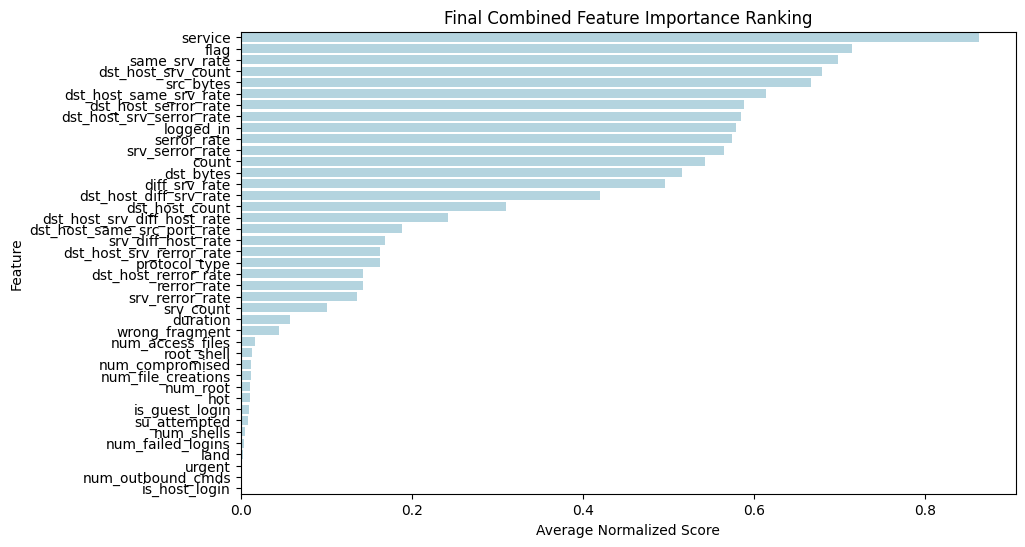

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

combined_series = pd.Series(combined_final)
plt.figure(figsize=(10,6))
sns.barplot(x=combined_series.values, y=combined_series.index, color='lightblue')
plt.title('Final Combined Feature Importance Ranking')
plt.xlabel('Average Normalized Score')
plt.ylabel('Feature')
plt.show()


## Building Bayes Network

Selecting top 18 features

In [ ]:
# Get top 18 features
top_features = list(combined_final.keys())[:18]
print(f"Top 18 features: {top_features}")

# Prepare data for Bayesian Network
df_bn = df[top_features + ['label']].copy()

# Discretize continuous features
continuous_cols = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
                   'serror_rate', 'srv_serror_rate', 'same_srv_rate']

# for col in continuous_cols:
#     if col in df_bn.columns:
#         df_bn[col] = pd.cut(df_bn[col], bins=3, labels=['low', 'medium', 'high'])

for col in continuous_cols:
    if col in df_bn.columns:
        # Convert to numeric
        df_bn[col] = pd.to_numeric(df_bn[col], errors='coerce')

        # Only discretize if there are valid numeric values
        if df_bn[col].notna().sum() > 0:
            df_bn[col] = pd.cut(df_bn[col], bins=3, labels=['low', 'medium', 'high'])
            # Fill any remaining NaNs
            df_bn[col] = df_bn[col].cat.add_categories('unknown').fillna('unknown')
        else:
            # If column is completely non-numeric, just mark as 'unknown'
            df_bn[col] = 'unknown'

print(f"Data prepared: {df_bn.shape}")
print(df_bn.head())



Top 18 features: ['service', 'flag', 'same_srv_rate', 'dst_host_srv_count', 'src_bytes', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'logged_in', 'serror_rate', 'srv_serror_rate', 'count', 'dst_bytes', 'diff_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_count', 'dst_host_srv_diff_host_rate', 'dst_host_same_src_port_rate']
Data prepared: (10000, 19)
        service  flag same_srv_rate  dst_host_srv_count src_bytes  \
378    domain_u    SF          high                 171       low   
32038      http    S0           low                  44       low   
86399     pop_3    S0           low                  20       low   
74412   private   REJ           low                  27       low   
52951   private  RSTR          high                   1       low   

       dst_host_same_srv_rate  dst_host_serror_rate  dst_host_srv_serror_rate  \
378                      1.00                  0.00                       0.0   
32038                    0.17        

Learning the Bayes NEt

In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
# Use ONLY top 10 most correlated features
top_features = ['service', 'flag', 'logged_in', 'serror_rate',
                'srv_serror_rate', 'dst_host_srv_count', 'same_srv_rate',
                'dst_host_same_srv_rate', 'count', 'protocol_type']

df_bn = df[top_features + ['label']].copy()

# Discretize
continuous_cols = ['serror_rate', 'srv_serror_rate', 'same_srv_rate', 'count']

for col in continuous_cols:
    if col in df_bn.columns:
        df_bn[col] = pd.cut(df_bn[col], bins=3,
                            labels=['low', 'medium', 'high'],
                            duplicates='drop')

# Convert to string
for col in df_bn.columns:
    df_bn[col] = df_bn[col].astype(str)

# Use sample
df_sample = df_bn.sample(n=min(5000, len(df_bn)), random_state=42)

print("Learning network structure (MMHC)...")
mmhc = MmhcEstimator(df_sample)
model = mmhc.estimate()

print("✓ Structure learned!")
print(f"Nodes: {model.nodes()}")
print(f"Edges: {model.edges()}")

# Fit
model.fit(df_sample, estimator=MaximumLikelihoodEstimator)
print("✓ Model trained!")


Learning network structure (MMHC)...


  0%|          | 0/1000000 [00:00<?, ?it/s]

✓ Structure learned!
Nodes: ['service', 'flag', 'logged_in', 'serror_rate', 'srv_serror_rate', 'dst_host_srv_count', 'same_srv_rate', 'dst_host_same_srv_rate', 'count', 'protocol_type', 'label']
Edges: [('service', 'protocol_type'), ('service', 'label'), ('service', 'flag'), ('service', 'count'), ('flag', 'srv_serror_rate'), ('flag', 'same_srv_rate'), ('flag', 'label'), ('flag', 'serror_rate'), ('logged_in', 'service'), ('logged_in', 'flag'), ('logged_in', 'protocol_type'), ('srv_serror_rate', 'serror_rate'), ('dst_host_same_srv_rate', 'dst_host_srv_count'), ('count', 'same_srv_rate'), ('count', 'serror_rate'), ('protocol_type', 'dst_host_same_srv_rate'), ('protocol_type', 'flag'), ('protocol_type', 'same_srv_rate'), ('label', 'dst_host_same_srv_rate'), ('label', 'same_srv_rate'), ('label', 'count'), ('label', 'srv_serror_rate')]
✓ Model trained!


/tmp/ipython-input-2751082445.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


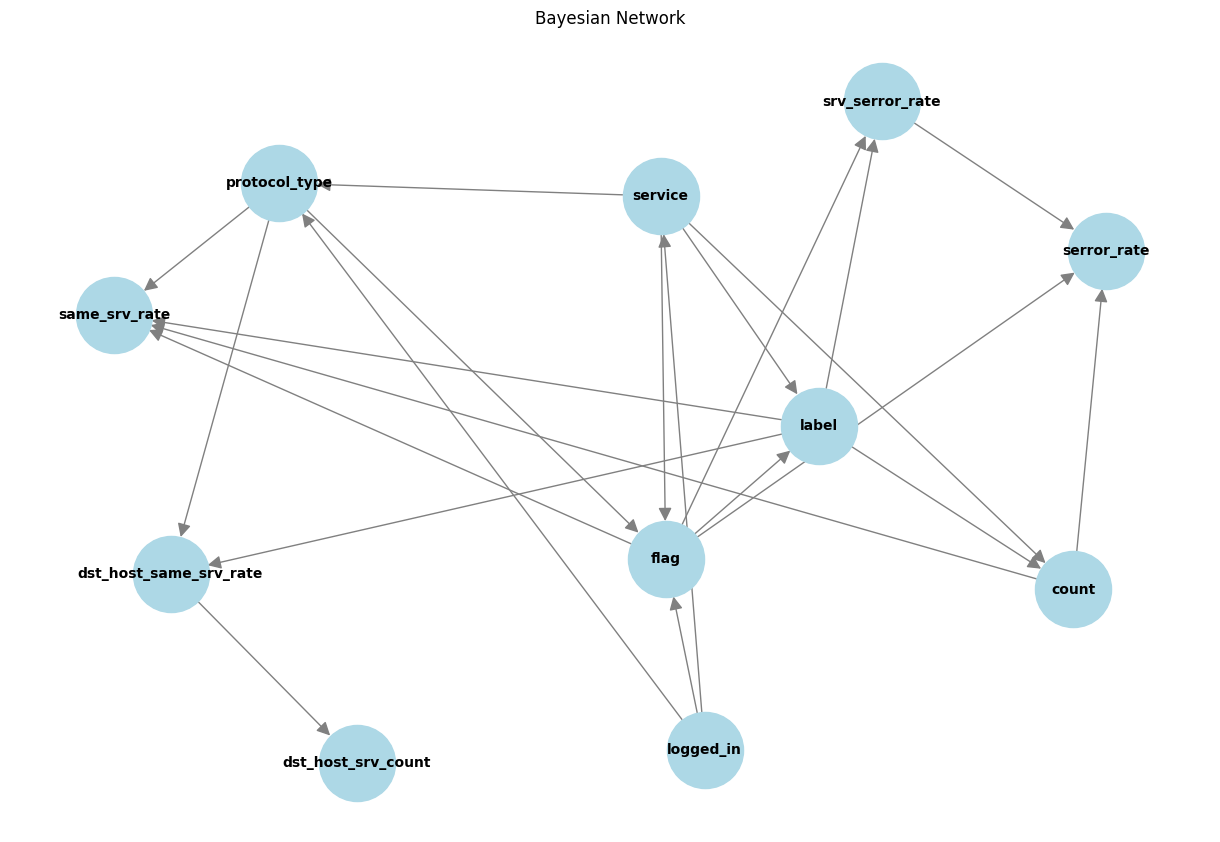

Network visualization saved!


In [ ]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2, iterations=50)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=3000, font_size=10, font_weight='bold',
        arrows=True, arrowsize=20, edge_color='gray')
plt.title("Bayesian Network")
plt.tight_layout()
plt.savefig('bayesian_network.png', dpi=150)
plt.show()

print("Network visualization saved!")


In [ ]:
print("\n" + "="*70)
print("BAYESIAN NETWORK STRUCTURE")
print("="*70)

for node in sorted(model.nodes()):
    parents = [edge[0] for edge in model.edges() if edge[1] == node]
    children = [edge[1] for edge in model.edges() if edge[0] == node]

    print(f"\n{node}:")
    print(f"  ← Parents:  {parents if parents else 'None'}")
    print(f"  → Children: {children if children else 'None'}")



BAYESIAN NETWORK STRUCTURE

count:
  ← Parents:  ['service', 'label']
  → Children: ['same_srv_rate', 'serror_rate']

dst_host_same_srv_rate:
  ← Parents:  ['protocol_type', 'label']
  → Children: ['dst_host_srv_count']

dst_host_srv_count:
  ← Parents:  ['dst_host_same_srv_rate']
  → Children: None

flag:
  ← Parents:  ['service', 'logged_in', 'protocol_type']
  → Children: ['srv_serror_rate', 'same_srv_rate', 'label', 'serror_rate']

label:
  ← Parents:  ['service', 'flag']
  → Children: ['dst_host_same_srv_rate', 'same_srv_rate', 'count', 'srv_serror_rate']

logged_in:
  ← Parents:  None
  → Children: ['service', 'flag', 'protocol_type']

protocol_type:
  ← Parents:  ['service', 'logged_in']
  → Children: ['dst_host_same_srv_rate', 'flag', 'same_srv_rate']

same_srv_rate:
  ← Parents:  ['flag', 'count', 'protocol_type', 'label']
  → Children: None

serror_rate:
  ← Parents:  ['flag', 'srv_serror_rate', 'count']
  → Children: None

service:
  ← Parents:  ['logged_in']
  → Children: 

In [ ]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MmhcEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination


bn = DiscreteBayesianNetwork(model.edges())  # ← Changed!
bn.fit(df_sample, estimator=MaximumLikelihoodEstimator)

print("Model trained!")

# 3. Inference
infer = VariableElimination(bn)

# 4. Test
result = infer.query(variables=['label'],
                    evidence={'service': 'http', 'flag': 'SF'})
print(result)


Model trained!
+---------------+--------------+
| label         |   phi(label) |
+===============+==============+
| label(Attack) |       0.0224 |
+---------------+--------------+
| label(Normal) |       0.9776 |
+---------------+--------------+


In [ ]:
import numpy as np

print("\n" + "="*70)
print("FINAL SUMMARY REPORT")
print("="*70)

print("\n1. TOP 15 FEATURES (By Combined Ranking):")
for i, (feat, score) in enumerate(combined_final.items(), 1):
    # Handle NaN values
    if np.isnan(score):
        print(f"  {i:2}. {feat:25s} {'N/A':>6s} (undefined)")
    else:
        bar = "█" * int(score * 50)
        print(f"  {i:2}. {feat:25s} {score:.4f} {bar}")

print("\n2. NETWORK STRUCTURE:")
print(f"  Total nodes: {len(model.nodes())}")
print(f"  Total edges: {len(model.edges())}")

print("\n3. TOP 8 FEATURES FOR RESEARCH:")
top_8 = [f for f, s in combined_final.items() if not np.isnan(s)][:8]
for i, feat in enumerate(top_8, 1):
    print(f"  {i}. {feat}")

print("\n Analysis Complete!")



FINAL SUMMARY REPORT

1. TOP 15 FEATURES (By Combined Ranking):
   1. service                   0.8623 ███████████████████████████████████████████
   2. flag                      0.7148 ███████████████████████████████████
   3. same_srv_rate             0.6979 ██████████████████████████████████
   4. dst_host_srv_count        0.6794 █████████████████████████████████
   5. src_bytes                 0.6667 █████████████████████████████████
   6. dst_host_same_srv_rate    0.6137 ██████████████████████████████
   7. dst_host_serror_rate      0.5878 █████████████████████████████
   8. dst_host_srv_serror_rate  0.5845 █████████████████████████████
   9. logged_in                 0.5791 ████████████████████████████
  10. serror_rate               0.5739 ████████████████████████████
  11. srv_serror_rate           0.5642 ████████████████████████████
  12. count                     0.5428 ███████████████████████████
  13. dst_bytes                 0.5158 █████████████████████████
  14. diff_sr

In [ ]:
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

df_test = pd.read_csv('KDDTest+.txt', names=columns)
print(df_test.shape)

# Convert test data to binary (match training)
df_test['label'] = df_test['label'].apply(
    lambda x: 'Normal' if x.strip() == 'normal' else 'Attack'
)

print("Test label distribution after binarization:")
print(df_test['label'].value_counts())


(22544, 43)
Test label distribution after binarization:
label
Attack    12833
Normal     9711
Name: count, dtype: int64


In [ ]:
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd

# Load test data
df_test = pd.read_csv('KDDTest+.txt', names=columns)
print(df_test.shape)

# Convert test labels to binary (match training)
df_test['label'] = df_test['label'].apply(
    lambda x: 'Normal' if x.strip() == 'normal' else 'Attack'
)

print("Test label distribution after binarization:")
print(df_test['label'].value_counts())

# CRITICAL FIX: Discretize test data EXACTLY like training data
continuous_cols = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
                   'serror_rate', 'srv_serror_rate', 'same_srv_rate']

df_test_processed = df_test.copy()

for col in continuous_cols:
    if col in df_test_processed.columns:
        # Convert to numeric first
        df_test_processed[col] = pd.to_numeric(df_test_processed[col], errors='coerce')

        # Discretize with SAME bins as training (3 bins)
        df_test_processed[col] = pd.cut(df_test_processed[col], bins=3,
                                        labels=['low', 'medium', 'high'],
                                        duplicates='drop')

        # Convert to string IMMEDIATELY to avoid categorical issues
        df_test_processed[col] = df_test_processed[col].astype(str)

        # Replace NaN strings with 'unknown'
        df_test_processed[col] = df_test_processed[col].replace('nan', 'unknown')

# Convert all remaining columns to string for inference
for col in df_test_processed.columns:
    df_test_processed[col] = df_test_processed[col].astypef(str)

# Get features in BN (excluding label)
bn_features = [f for f in list(bn.nodes()) if f != 'label']

print(f"\nFeatures in Bayesian Network: {bn_features}")

# Create inference engine
infer = VariableElimination(bn)

# Make predictions on test data
predictions = []
true_labels = []

print("\nMaking predictions...")
error_count = 0

for idx, row in df_test_processed.iterrows():
    # Only use features that exist in the network
    evidence = {feat: str(row[feat]) for feat in bn_features if feat in df_test_processed.columns}

    try:
        result = infer.query(variables=['label'], evidence=evidence)
        predicted = result.state_names['label'][np.argmax(result.values)]
        predictions.append(predicted)
        true_labels.append(str(row['label']))
    except Exception as e:
        predictions.append('unknown')
        true_labels.append(str(row['label']))
        error_count += 1
        if error_count <= 3:
            print(f"Error at row {idx}: {e}")

# Calculate metrics
print("\n" + "="*70)
print("MODEL PERFORMANCE (BINARY CLASSIFICATION)")
print("="*70)

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)

print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(true_labels, predictions))

# Check predictions
print("\nPrediction distribution:")
print(pd.Series(predictions).value_counts())


(22544, 43)
Test label distribution after binarization:
label
Attack    12833
Normal     9711
Name: count, dtype: int64

Features in Bayesian Network: ['service', 'protocol_type', 'flag', 'count', 'srv_serror_rate', 'same_srv_rate', 'serror_rate', 'logged_in', 'dst_host_same_srv_rate', 'dst_host_srv_count']

Making predictions...
Error at row 170: "state: 187 is an unknown for variable: dst_host_srv_count. It must be one of ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', 

/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / (phi.values.sum())


Error at row 1413: "state: pm_dump is an unknown for variable: service. It must be one of ['IRC', 'X11', 'Z39_50', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'hostnames', 'http', 'http_443', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pop_2', 'pop_3', 'printer', 'private', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'time', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois']"
Error at row 1493: "state: 187 is an unknown for variable: dst_host_srv_count. It must be one of ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '12

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
